C:\Users\gribo\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\gribo\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
XGBoost version 1.7.1 has not been tested with coremltools. You may run into unexpected errors. XGBoost 1.4.2 is the most recent version that has been tested.


TensorFlow version 2.15.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.
Fail to import BlobReader from libmilstoragepython. No module named 'coremltools.libmilstoragepython'
Fail to import BlobWriter from libmilstoragepython. No module named 'coremltools.libmilstoragepython'


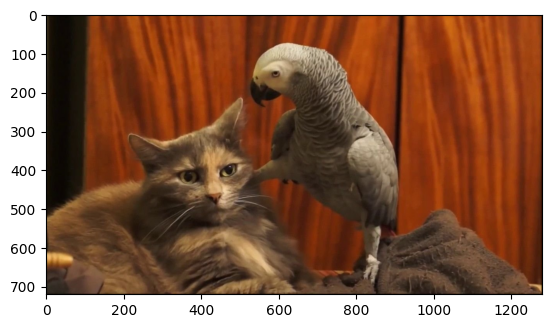

In [1]:
import torch
import numpy as np
import torchvision
import onnx
from torchvision.models import *
from torchvision.models.quantization import *
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.io import read_image
import onnxruntime as ort
import cv2
import coremltools as ct
way="example1.jpg"
img = cv2.imread(way)
plt.imshow(plt.imread(way))

In [2]:
def img2tensor(img: np.ndarray, mean: list, std: list, size: int = 224) -> torch.Tensor:
    t = cv2.resize(img, (size,size), interpolation=cv2.INTER_AREA)
    t = torch.from_numpy(t.astype(np.float32)/ 255.0) # 0..255->0..1
    t = t.permute(2,0,1) # hwc -> chw
    _m = torch.FloatTensor(mean).unsqueeze(1).unsqueeze(1) #cx1x1
    _s = torch.FloatTensor(std).unsqueeze(1).unsqueeze(1)
    t = (t - _m) / (_s + 1E-7)
    return t
tensor_img1 = img2tensor(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).unsqueeze(0)
print(tensor_img1.shape)

torch.Size([1, 3, 224, 224])


In [3]:
model = torchvision.models.mnasnet1_0(weights=MNASNet1_0_Weights.IMAGENET1K_V1)
model.eval()

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [4]:
with torch.no_grad():tensor_img1_out = model(tensor_img1)
print(tensor_img1_out)

tensor([[-3.4809e+00,  1.5885e+00, -1.2226e+00, -7.1340e-01, -2.0335e+00,
         -1.3482e+00, -5.0324e+00,  2.8046e+00,  4.7026e+00, -3.0132e+00,
         -1.5032e+00, -8.7899e-02,  2.6191e+00, -1.3969e-01, -4.1903e-01,
          4.2939e+00,  2.8398e+00,  6.9151e+00,  1.6512e-01,  2.7822e-01,
          4.6083e+00,  7.6543e+00,  4.3801e+00,  5.7675e+00,  4.9257e+00,
         -3.7469e+00, -3.6957e+00, -4.8217e+00, -3.1185e+00,  6.8932e-03,
         -4.8419e+00, -5.7633e-01, -3.7167e+00, -2.1752e-01,  1.4015e+00,
         -3.0575e+00,  1.5914e+00, -1.0462e+00, -4.0459e+00, -6.6499e-01,
         -3.0073e+00, -3.2853e+00, -1.9604e+00,  3.2473e-01, -2.4340e+00,
         -3.0301e+00, -3.0297e+00, -1.7210e+00, -1.3613e+00, -7.5143e+00,
         -4.8148e+00,  2.1101e+00, -2.9803e+00, -3.3417e+00, -2.0026e+00,
         -1.8664e+00, -3.4569e+00, -4.3578e+00, -2.6845e+00, -2.6097e+00,
         -1.2065e+00, -2.7847e+00, -2.8290e+00,  3.7854e-01,  7.5232e-01,
         -4.3734e+00, -1.8067e+00, -4.

In [5]:
out_probs = torch.nn.functional.softmax(tensor_img1_out[0], dim = 0)
!curl https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -o imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:categories = [s.strip() for s in f.readlines()]
prob, category_id = torch.topk(out_probs, 5)
for i in range(prob.size(0)):
    print(categories[category_id[i]], prob[i].item())

Egyptian cat 0.5914875268936157
African grey 0.22076784074306488
tiger cat 0.040007300674915314
tabby 0.03903419151902199
Persian cat 0.035435207188129425


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10472  100 10472    0     0  26622      0 --:--:-- --:--:-- --:--:-- 26646


In [6]:
dummy_input = torch.randn(1, 3, 224, 224)
input_names = [ "img_input" ]
output_names = [ "output1" ]
torch.onnx.export(model, dummy_input, "mnasnet1_0.onnx", verbose=True, input_names=input_names, output_names=output_names)
# Load the ONNX model
model_onnx = onnx.load("mnasnet1_0.onnx")
onnx.checker.check_model(model_onnx)
#print(onnx.helper.printable_graph(model_onnx.graph))

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [7]:
ort_session = ort.InferenceSession("mnasnet1_0.onnx",providers=['CPUExecutionProvider'])
model_input_name = ort_session.get_inputs()[0].name
model_output_name = ort_session.get_outputs()[0].name
x = tensor_img1.numpy()
out = ort_session.run(
    [model_output_name],
    {model_input_name: x}
)
print(out[0])
'''
python -m pip install -U pip
pip uninstall -y onnx onnxruntime onnxruntime-gpu onnxruntime-silicon
pip uninstall -y onnxruntime-extensions <<<<< This i didn't have it, but i tried.
pip install onnx==1.14.0 onnxruntime==1.15.0
'''

[[-3.48087978e+00  1.58850527e+00 -1.22259307e+00 -7.13399231e-01
  -2.03348780e+00 -1.34816265e+00 -5.03239775e+00  2.80462980e+00
   4.70259476e+00 -3.01316142e+00 -1.50319624e+00 -8.78985524e-02
   2.61912346e+00 -1.39689326e-01 -4.19022560e-01  4.29389334e+00
   2.83980560e+00  6.91514111e+00  1.65121436e-01  2.78222442e-01
   4.60826349e+00  7.65426493e+00  4.38005733e+00  5.76745033e+00
   4.92571449e+00 -3.74687624e+00 -3.69574332e+00 -4.82166147e+00
  -3.11853504e+00  6.89303875e-03 -4.84191990e+00 -5.76322556e-01
  -3.71669626e+00 -2.17509970e-01  1.40154743e+00 -3.05749702e+00
   1.59141207e+00 -1.04621279e+00 -4.04591513e+00 -6.64983213e-01
  -3.00727010e+00 -3.28534412e+00 -1.96044230e+00  3.24731708e-01
  -2.43402839e+00 -3.03006697e+00 -3.02968979e+00 -1.72096872e+00
  -1.36131477e+00 -7.51434278e+00 -4.81479502e+00  2.11010385e+00
  -2.98034143e+00 -3.34173203e+00 -2.00256062e+00 -1.86644149e+00
  -3.45688581e+00 -4.35776043e+00 -2.68448973e+00 -2.60968781e+00
  -1.20651

"\npython -m pip install -U pip\npip uninstall -y onnx onnxruntime onnxruntime-gpu onnxruntime-silicon\npip uninstall -y onnxruntime-extensions <<<<< This i didn't have it, but i tried.\npip install onnx==1.14.0 onnxruntime==1.15.0\n"

In [8]:
np.linalg.norm(out[0]-tensor_img1_out.numpy())

9.0117945e-05

In [9]:
traced_model = torch.jit.trace(model, dummy_input)

In [10]:
ml_model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=dummy_input.shape)]
 )
ml_model.save("mnasnet1_0.mlpackage")

Running MIL default pipeline:   0%|                                                        | 0/71 [00:00<?, ? passes/s]C:\Users\gribo\AppData\Local\Programs\Python\Python39\lib\site-packages\coremltools\converters\mil\mil\passes\defs\preprocess.py:239: UserWarning: Input, 'x.1', of the source model, has been renamed to 'x_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|████████████████████████████████████| 12/12 [00:00<00:00, 632.17 passes/s]


RuntimeError: BlobWriter not loaded